# Projet Apprentissage Automatique Supervisé
Réalisé par BISAGA Nicolas et VALENTE Hugo en L3 Info, UFR MIM Metz.

In [91]:
# librairies et versions
# Pandas version : 2.3.3
# Matplotlib version : 3.10.7
# Seaborn version : 0.13.2
# Scikit-learn version : 1.7.2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

print("Bibliothèques importées avec succès.")


Bibliothèques importées avec succès.


## Étape 1 : Choix et compréhension du dataset
### 1. Création du dataset à partir des 4 fichiers csv de 2019

In [92]:

# Chargement des fichiers
carac = pd.read_csv("caracteristiques-2019.csv", sep=";", low_memory=False)
lieux = pd.read_csv("lieux-2019.csv", sep=";", low_memory=False)
vehicules = pd.read_csv("vehicules-2019.csv", sep=";", low_memory=False)
usagers = pd.read_csv("usagers-2019.csv", sep=";", low_memory=False)

# Fusion des tables
# Fusion caractéristiques + lieux
df = carac.merge(lieux, on="Num_Acc", how="left")

# Fusion avec véhicules
df = df.merge(vehicules, on="Num_Acc", how="left")

# Fusion avec usagers
df = df.merge(usagers, on="Num_Acc", how="left")

# Résultat final
print("Dataset final :", df.shape)
df.head()

Dataset final : (253488, 56)


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,...,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,2002,0,1,0,-1,-1,-1,-1
1,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,1993,5,1,0,-1,-1,-1,-1
2,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,1,1,1959,0,1,0,-1,-1,-1,-1
3,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,2002,0,1,0,-1,-1,-1,-1
4,201900000001,30,11,2019,01:30,4,93,93053,1,1,...,4,2,1993,5,1,0,-1,-1,-1,-1


### 2. Présentation brève du jeu de données (origine, variables, taille, objectif)
Origine : Le jeu de données df est issu de la fusion de quatre fichiers CSV sur les accidents de la route en 2019 (caractéristiques, lieux, véhicules et usagers). Ces données proviennent du site web data.gouv.fr.

Variables : Il combine des informations sur les accidents (date, localisation, conditions météo), les lieux (type de route, vitesse autorisée), les véhicules (type) et les usagers (âge, gravité des blessures, sexe). Les clés de fusion sont Num_Acc (numéro d'accident).

Taille : La taille est de 253488 lignes et 56 colonnes.

Objectif : Analyser les facteurs influençant la gravité des accidents corporels et construire un modèle capable de prédire cette gravité à partir des caractéristiques disponibles.

### 3. Description de la tâche
La variable cible choisie est grav, qui indique le niveau de gravité de l’accident corporel (blessures légères, graves, décès, etc.).
La tâche est une classification supervisée multi-classes, car :
- la variable cible est catégorielle,
- elle comporte plusieurs modalités représentant différents niveaux de gravité.

## Étape 2 : Nettoyage / Data Cleaning
- Détection et traitement des valeurs manquantes.
- Gestion des doublons.
- Standardisation des formats.
- Détection des outliers.
- Encodage des variables catégorielles.
- Normalisation ou standardisation.

In [93]:
# 1. Suppression des lignes sans variable cible
df = df.dropna(subset=["grav"])

# 2. Transformation de an_nais en âge (2019 - an_nais)
df["age"] = 2019 - df["an_nais"]

# 3. Sélection des variables pertinentes
variablesPertinentes = [
    "age",      # âge de l'usager
    "sexe",     # sexe de l'usager
    "catv",     # catégorie de véhicule
    "lum",      # luminosité lors de l'accident
    "atm",      # conditions météorologiques
    "agg",      # agglomération
    "catr"      # catégorie de route
]

df = df[variablesPertinentes + ["grav"]]

# 4. Traitement des valeurs aberrantes sur l'âge
df = df[(df["age"] >= 0) & (df["age"] <= 120)]

# 5. Traitement des valeurs manquantes
# On remplace :
# - par la médiane pour les variables numériques
# - par la modalité la plus fréquente pour les catégorielles

df["age"] = df["age"].fillna(df["age"].median())

for col in df.select_dtypes(include="object"):
    df[col] = df[col].fillna(df[col].mode()[0])

# 6. Vérification des doublons
df = df.drop_duplicates()

# 7. Vérification finale du dataset nettoyé
print("Taille finale du dataset :", df.shape)
df.head()

Taille finale du dataset : (68500, 8)


,age,sexe,catv,lum,atm,agg,catr,grav
0,17,2,7,4,1,1,1,4
1,26,2,7,4,1,1,1,4
2,60,1,7,4,1,1,1,1
3,17,2,17,4,1,1,1,4
4,26,2,17,4,1,1,1,4


## Étape 3 : Analyse Exploratoire (EDA)
- Statistiques descriptives.
- Distribution des variables cibles et explicatives.
- Corrélations et heatmaps.
- Visualisations pertinentes.
- Analyse des relations importantes.

Statistiques descriptives pour les variables numériques :
                age          sexe          catv           lum           atm  \
count  68500.000000  68500.000000  68500.000000  68500.000000  68500.000000   
mean      41.101927      1.339664     16.698423      2.143474      2.248847   
std       20.377366      0.473599     16.536281      1.529888      2.274663   
min        0.000000      1.000000      0.000000      1.000000     -1.000000   
25%       25.000000      1.000000      7.000000      1.000000      1.000000   
50%       39.000000      1.000000      7.000000      1.000000      1.000000   
75%       55.000000      2.000000     31.000000      3.000000      2.000000   
max      119.000000      2.000000     99.000000      5.000000      9.000000   

                agg          catr          grav  
count  68500.000000  68500.000000  68500.000000  
mean       1.572599      3.272949      2.527124  
std        0.494705      1.548364      1.324637  
min        1.000000      1.000

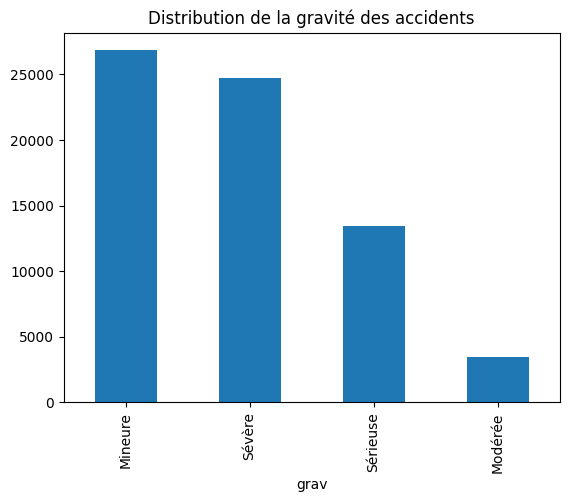

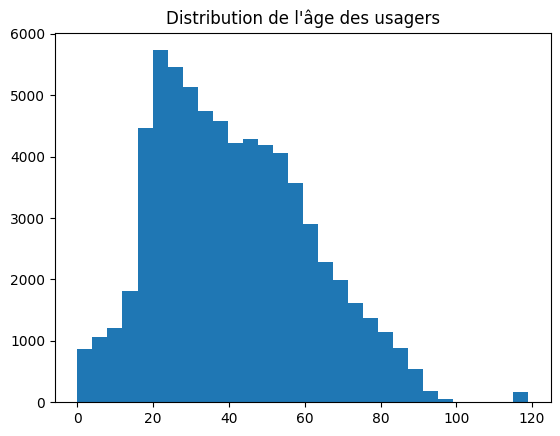

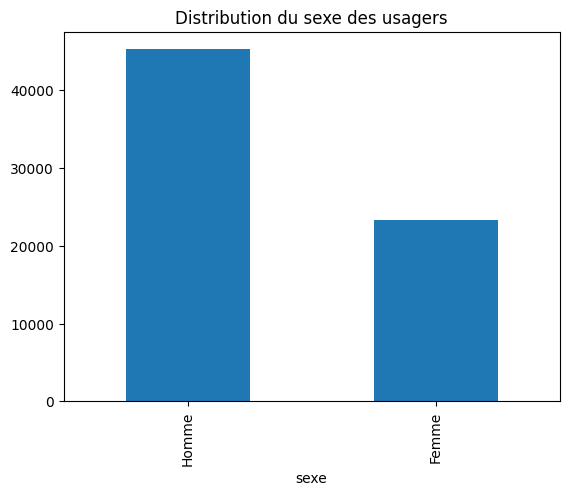

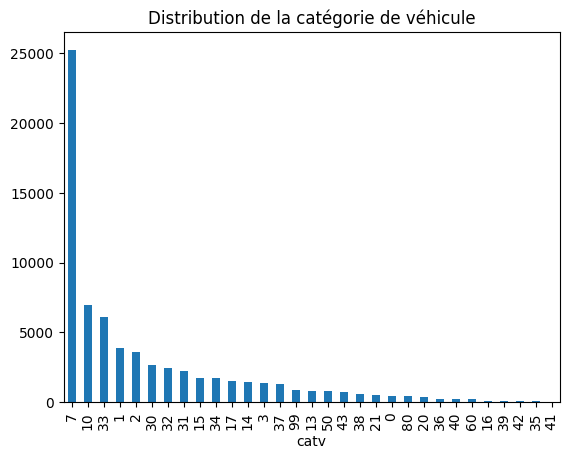

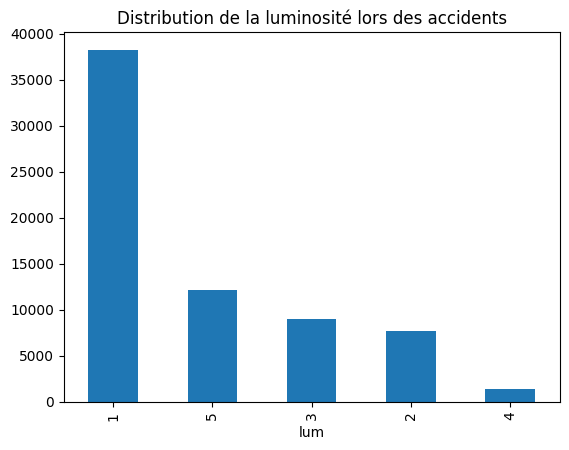

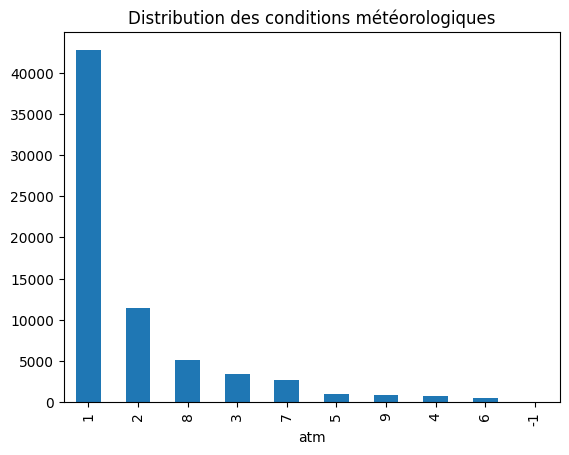

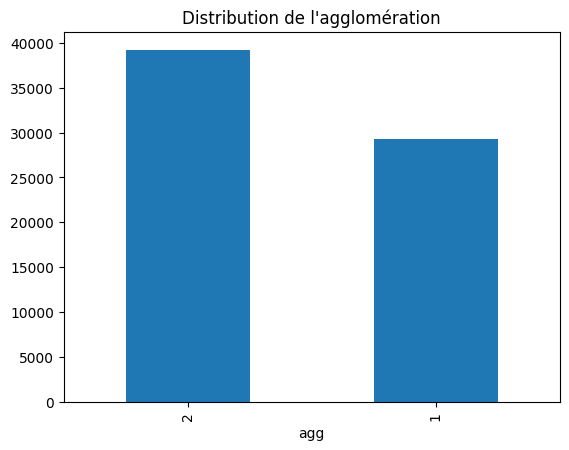

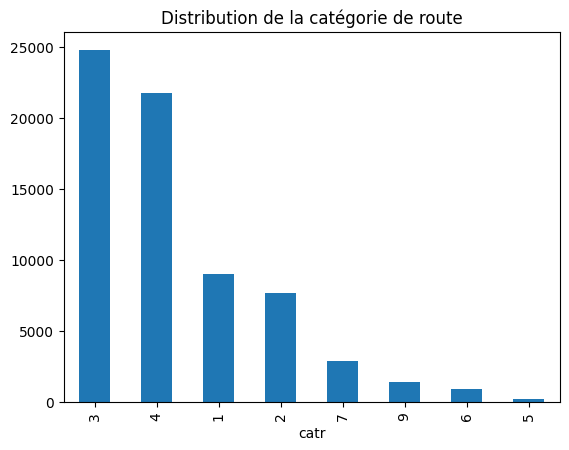

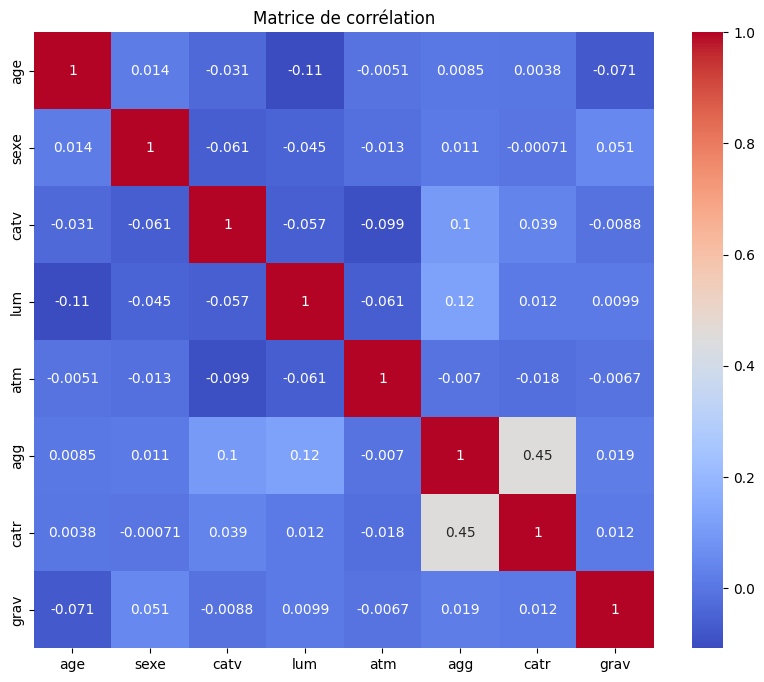

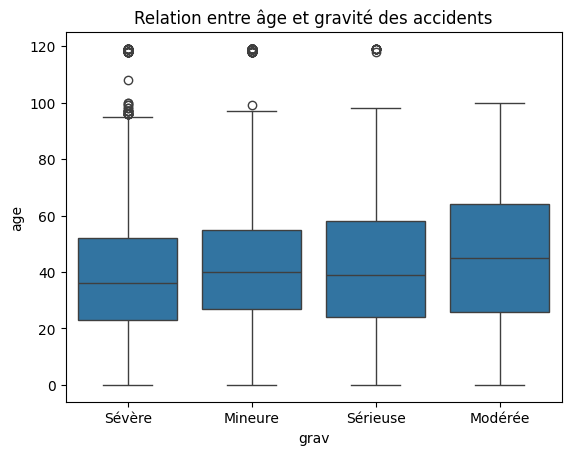

- La corrélation entre âge et gravité montre une tendance (âge moyen par gravité).
- Moyenne d'âge par gravité : grav
1    42.133182
2    46.558408
3    41.890159
4    38.788848
Name: age, dtype: float64


<Figure size 640x480 with 0 Axes>

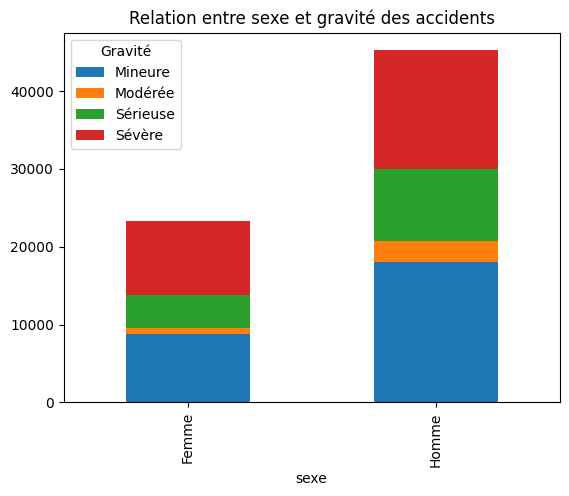

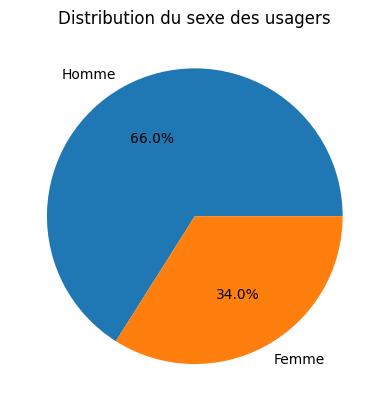

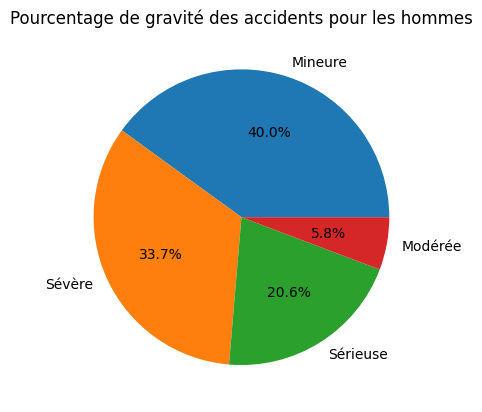

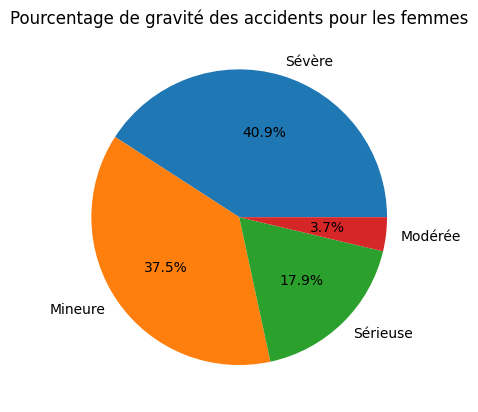

In [94]:
# Statistiques descriptives
print("Statistiques descriptives pour les variables numériques :")
print(df.describe())

print("\nStatistiques pour les variables catégorielles :")
for col in df.select_dtypes(include="object").columns:
    print(f"\n{col} :")
    print(df[col].value_counts())

# Distribution des variables cibles et explicatives
# Distribution de la variable cible
plt.figure()
df["grav"].replace({1: "Mineure", 2: "Modérée", 3: "Sérieuse", 4: "Sévère"}).value_counts().plot(kind="bar")
plt.title("Distribution de la gravité des accidents")
plt.show()

# Distribution de l'âge
plt.figure()
plt.hist(df["age"], bins=30)
plt.title("Distribution de l'âge des usagers")
plt.show()

# Distribution du sexe
plt.figure()
df["sexe"].replace({1: "Homme", 2: "Femme"}).value_counts().plot(kind="bar")
plt.title("Distribution du sexe des usagers")
plt.show()

# Distribution de la catégorie de véhicule
plt.figure()
df["catv"].value_counts().plot(kind="bar")
plt.title("Distribution de la catégorie de véhicule")
plt.show()

# Distribution de la luminosité
plt.figure()
df["lum"].value_counts().plot(kind="bar")
plt.title("Distribution de la luminosité lors des accidents")
plt.show()

# Distribution des conditions météorologiques
plt.figure()
df["atm"].value_counts().plot(kind="bar")
plt.title("Distribution des conditions météorologiques")
plt.show()

# Distribution de l'agglomération
plt.figure()
df["agg"].value_counts().plot(kind="bar")
plt.title("Distribution de l'agglomération")
plt.show()

# Distribution de la catégorie de route
plt.figure()
df["catr"].value_counts().plot(kind="bar")
plt.title("Distribution de la catégorie de route")
plt.show()

# Corrélations et heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

# On choisit l'age et le sexe car ce sont les deux variables avec le plus haut taux de corrélation avec la variable cible grav
# Relation âge vs gravité
plt.figure()
sns.boxplot(x="grav", y="age", data=df.replace({"grav": {1: "Mineure", 2: "Modérée", 3: "Sérieuse", 4: "Sévère"}}))
plt.title("Relation entre âge et gravité des accidents")
plt.show()
print("- La corrélation entre âge et gravité montre une tendance (âge moyen par gravité).")
print("- Moyenne d'âge par gravité :", df.groupby("grav")["age"].mean())

# Relation sexe vs gravité
plt.figure()
pd.crosstab(df["sexe"].replace({1: "Homme", 2: "Femme"}), df["grav"].replace({1: "Mineure", 2: "Modérée", 3: "Sérieuse", 4: "Sévère"})).plot(kind="bar", stacked=True)
plt.title("Relation entre sexe et gravité des accidents")
plt.legend(title="Gravité")
plt.show()

# Distribution du sexe
plt.figure()
df["sexe"].replace({1: "Homme", 2: "Femme"}).value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title("Distribution du sexe des usagers")
plt.ylabel("")  # Supprimer le label y pour un camembert
plt.show()

# Distribution de la gravité par sexe
# Pour les hommes (sexe == 1)
plt.figure()
df[df["sexe"] == 1]["grav"].replace({1: "Mineure", 2: "Modérée", 3: "Sérieuse", 4: "Sévère"}).value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title("Pourcentage de gravité des accidents pour les hommes")
plt.ylabel("")
plt.show()

# Pour les femmes (sexe == 2)
plt.figure()
df[df["sexe"] == 2]["grav"].replace({1: "Mineure", 2: "Modérée", 3: "Sérieuse", 4: "Sévère"}).value_counts().plot(kind="pie", autopct='%1.1f%%')
plt.title("Pourcentage de gravité des accidents pour les femmes")
plt.ylabel("")
plt.show()



## Étape 4 : Préparation et séparation des données
Split train/test.

In [95]:
X = df.drop("grav", axis=1)
y = df["grav"]

num_features = ["age"]
cat_features = [col for col in X.columns if col not in num_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", "passthrough", cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Étape 5 : Construction d’un modèle de ML
Tester au moins deux modèles.

Validation croisée.

In [96]:
# Modèle 1 : Régression logistique
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Modèle 2 : Random Forest
rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Validation croisée
print("Validation croisée pour Logistic Regression :", cross_val_score(log_reg, X_train, y_train, cv=5, scoring='accuracy').mean())
print("Validation croisée pour Random Forest :", cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean())


Validation croisée pour Logistic Regression : 0.2896715328467153
Validation croisée pour Random Forest : 0.24932481751824817


## Étape 6 : Évaluation
Classification : Accuracy, F1-score, Matrice de confusion, ROC-AUC

In [97]:
for name, model in {
    "Logistic Regression": log_reg,
    "Random Forest": rf
}.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    print("\n", name)
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred, average="macro"))
    print("ROC-AUC (OVR) :", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))


 Logistic Regression
Accuracy : 0.2983941605839416
F1-score : 0.2559400014805835
ROC-AUC (OVR) : 0.5849610389341873
Matrice de confusion :
 [[1189 1771  444 1962]
 [  90  418   51  134]
 [ 495 1041  259  900]
 [ 932 1403  389 2222]]

 Random Forest
Accuracy : 0.2289051094890511
F1-score : 0.17271465199351974
ROC-AUC (OVR) : 0.43436751627509257
Matrice de confusion :
 [[1616  370 1217 2163]
 [ 177   25  309  182]
 [1032  317  273 1073]
 [2196  338 1190 1222]]


## Étape 7 : Interprétation
### Feature importance

In [98]:
# Feature importance pour Random Forest
rf_model = rf.named_steps['model']
feature_names = num_features + cat_features
importances = rf_model.feature_importances_
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

# Coefficients pour Logistic Regression (multi-classes)
log_reg_model = log_reg.named_steps['model']
coefficients = log_reg_model.coef_
for i, class_coef in enumerate(coefficients):
    print(f"Coefficients pour la classe {i+1} :")
    for name, coef in zip(feature_names, class_coef):
        print(f"  {name}: {coef:.4f}")

Feature: age, Importance: 0.5806
Feature: sexe, Importance: 0.0152
Feature: catv, Importance: 0.1876
Feature: lum, Importance: 0.0613
Feature: atm, Importance: 0.0723
Feature: agg, Importance: 0.0171
Feature: catr, Importance: 0.0658
Coefficients pour la classe 1 :
  age: -0.0097
  sexe: 0.0735
  catv: 0.0053
  lum: 0.0023
  atm: 0.0245
  agg: 0.3044
  catr: -0.0314
Coefficients pour la classe 2 :
  age: 0.2127
  sexe: -0.3703
  catv: -0.0083
  lum: 0.0085
  atm: -0.0381
  agg: -0.6383
  catr: 0.0192
Coefficients pour la classe 3 :
  age: -0.0195
  sexe: -0.0276
  catv: -0.0012
  lum: -0.0158
  atm: -0.0094
  agg: -0.0692
  catr: 0.0397
Coefficients pour la classe 4 :
  age: -0.1835
  sexe: 0.3243
  catv: 0.0041
  lum: 0.0049
  atm: 0.0230
  agg: 0.4030
  catr: -0.0274


### Analyse des erreurs :
- En regardant les matrices de confusion, on voit que les modèles ont du mal à prédire les classes 2 (Modérée) et 3 (Sérieuse), qui sont minoritaires. Par exemple, pour la Régression Logistique, la classe 2 a seulement 418 vrais positifs sur 693, et beaucoup d'erreurs vers les autres classes.
- Pour Random Forest, c'est encore pire, avec des prédictions très dispersées, comme 25 vrais positifs pour la classe 2 sur 693.
- Ça montre que nos données sont déséquilibrées, et nos variables ne suffisent pas à bien séparer les classes. L'âge est la variable la plus importante (0.58 pour Random Forest), suivi de la catégorie de véhicule (0.19), ce qui fait sens car les jeunes et certains véhicules sont plus risqués.
- Pour la Régression Logistique, les coefficients montrent par exemple que pour la classe 4 (Sévère), l'âge a un coefficient négatif (-0.18), ce qui signifie que les personnes plus âgées ont moins de chances d'avoir des accidents sévères, peut-être parce qu'ils conduisent moins.

### Recommandations :
- Pour améliorer nos modèles, on pourrait utiliser du SMOTE pour équilibrer les classes, ou ajouter des variables comme la vitesse ou l'état d'alcoolémie qui pourraient mieux expliquer la gravité.
- En termes de sécurité routière, on devrait cibler les jeunes conducteurs (âge important), et peut-être sensibiliser plus les hommes (sexe influence, coefficient positif pour classe 4).
- Aussi, les conditions comme l'agglomération (agg) semblent jouer un rôle (coefficient élevé pour classe 1 et 4), donc des campagnes en ville pourraient aider.
- En conclusion, nos modèles sont un bon début, mais avec plus de données ou de features, on pourrait les rendre plus fiables pour prédire la gravité des accidents.